**Importing Dependencies**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
import itertools
import tensorflow as tf
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Flatten, Concatenate,
                                      Dropout, Embedding, Bidirectional, LSTM,
                                      Reshape, TimeDistributed, GRU)
from collections import Counter
from sklearn.metrics import (classification_report,accuracy_score,
                             precision_score,recall_score,f1_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



**DATASET**


1. Primary amino acid sequence dataset obtained from Kaggle:
    https://www.kaggle.com/datasets/shahir/protein-data-set

2. Secondary structure dataset was obtained by using an automated code where we retrieve information from DSSP (Dictionary of Secondary Structure in Proteins) using BioPython


     The DSSP codes for secondary structure used here are:
     =====     ====
     Code      Structure
     =====     ====
     H         Alpha helix (4-12)
     B         Isolated beta-bridge residue
     E         Strand
     G         3-10 helix
     I         Pi helix
     T         Turn
     S         Bend
     P         K-helix
     -         None
     =====     ====
    
     if desired, convert DSSP's 8-state assignments into 3-state [C-coil, E - extended (beta-strand), H - helix].
     

**Installing and Importing Dependencies**

In [ ]:
pip install Biopython

In [ ]:
!apt-get install -y dssp

In [ ]:
!mkdssp --version

mkdssp version 4.0.4


In [ ]:
import logging
from Bio.PDB import PDBParser, PDBList
from Bio.PDB.DSSP import DSSP
from time import sleep
from google.colab import drive

In [ ]:
# Adapted from a script originally posted by https://www.biostars.org/u/56237/ on https://www.biostars.org/p/427294/#9514326
# The code retrieves secondary structure information of proteins using DSSP.
# I modified it to automatically process a list of PDB IDs.

# Mount Google Drive
drive.mount('/content/drive')

# Initialize logging
output_dir = "/content/drive/My Drive/protein_processing_batches1/"
os.makedirs(output_dir, exist_ok=True)
log_file = f"{output_dir}/protein_processing.log"

logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Initialize PDB downloader and parser
pdb_dl = PDBList()
parser = PDBParser(QUIET=True)

# Function to download a PDB file with retries and timeout
def download_pdb_file(pdb_id, retry_limit=3):
    pdb_file = f'./pdb{pdb_id.lower()}.ent'
    if os.path.exists(pdb_file):
        return pdb_file  # Skip if file already exists

    for attempt in range(retry_limit):
        try:
            logging.info(f"Downloading PDB file for {pdb_id} (Attempt {attempt + 1})")
            pdb_dl.retrieve_pdb_file(pdb_id.lower(), pdir='./', file_format='pdb', overwrite=False)
            return pdb_file
        except Exception as e:
            logging.warning(f"Failed to download {pdb_id}: {e}")
            sleep(5)  # Wait before retrying
    logging.error(f"Exceeded retry limit for {pdb_id}")
    return None

# Function to calculate secondary structure
def get_protein_features(pdb_id, chain_id):
    pdb_file = download_pdb_file(pdb_id)
    if not pdb_file:
        return None

    try:
        # Parse PDB file and calculate DSSP
        structure = parser.get_structure(pdb_id, pdb_file)
        model = structure[0]
        dssp = DSSP(model, pdb_file, file_type='PDB')

        # Extract features for the specified chain
        sequence = ''
        original_sec_structure = ''
        three_state_sec_structure = ''

        for key, value in dssp.property_dict.items():
            if key[0] == chain_id:
                sequence += value[1]
                original_sec_structure += value[2]

                # Convert 8-state DSSP to 3-state representation
                three_state_sec = value[2]
                three_state_sec = three_state_sec.replace('-', 'C').replace('I', 'H')
                three_state_sec = three_state_sec.replace('T', 'C').replace('S', 'C')
                three_state_sec = three_state_sec.replace('G', 'H').replace('P', 'H')
                three_state_sec = three_state_sec.replace('B', 'E')
                three_state_sec_structure += three_state_sec

        return {
            "sequence": sequence,
            "original_secondary_structure": original_sec_structure,
            "three_state_secondary_structure": three_state_sec_structure,
        }
    except Exception as e:
        logging.error(f"Error processing {pdb_id} chain {chain_id}: {e}")
        return None

# Function to process the dataframe in batches
def process_dataframe_in_batches(df, batch_size=1000, output_file_prefix="batch"):
    # Check for already processed batches
    processed_batches = [
        int(f.split('_')[1].split('.')[0])
        for f in os.listdir(output_dir) if f.startswith(output_file_prefix)
    ]

    for start_idx in range(0, len(df), batch_size):
        batch_number = start_idx // batch_size
        if batch_number in processed_batches:
            continue  # Skip already processed batches

        batch = df.iloc[start_idx:start_idx + batch_size]
        batch_results = []

        for _, row in batch.iterrows():
            features = get_protein_features(row["structureId"], row["chainId"])
            if features:
                batch_results.append({
                    "structureId": row["structureId"],
                    "chainId": row["chainId"],
                    "sequence": features["sequence"],
                    "original_secondary_structure": features["original_secondary_structure"],
                    "three_state_secondary_structure": features["three_state_secondary_structure"],
                })

        # Save results for the current batch
        batch_df = pd.DataFrame(batch_results)
        batch_output_file = f"{output_dir}/{output_file_prefix}_{batch_number}.csv"
        batch_df.to_csv(batch_output_file, index=False)
        logging.info(f"Saved batch {batch_number} to {batch_output_file}")

# Combine all batches into a single file
def combine_batches(output_file="final_results.csv"):
    all_batches = []
    for f in os.listdir(output_dir):
        if f.startswith('batch_') and f.endswith('.csv'):
            batch_df = pd.read_csv(os.path.join(output_dir, f))
            all_batches.append(batch_df)

    final_df = pd.concat(all_batches, ignore_index=True)
    final_output_file = f"{output_dir}/{output_file}"
    final_df.to_csv(final_output_file, index=False)
    logging.info(f"Combined all batches into {final_output_file}")

# Main execution
if __name__ == "__main__":
    # Load the dataframe
    input_file = "/content/drive/MyDrive/protein_processing_batches1/split_file_1 (1).csv"
    df = pd.read_csv(input_file)

    # Process the dataframe in batches
    process_dataframe_in_batches(df, batch_size=2000)

    # Combine results into a single file
    combine_batches()


**Preprocessing the Dataset**

In [ ]:
# Load data
# Primary structure dataset
data = pd.read_csv("/content/pdb_data_no_dups.csv")
sequences = pd.read_csv("/content/pdb_data_seq.csv")
# Secondary structure dataset
combined_data = pd.read_csv("/content/combined_sec_protein_features.csv")

**Secondary structure dataset informations**

In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210997 entries, 0 to 210996
Data columns (total 5 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   structureId                      210997 non-null  object
 1   chainId                          210997 non-null  object
 2   sequence                         204678 non-null  object
 3   original_secondary_structure     204678 non-null  object
 4   three_state_secondary_structure  204678 non-null  object
dtypes: object(5)
memory usage: 8.0+ MB


In [ ]:
print(combined_data.isnull().sum())

structureId                           0
chainId                               0
sequence                           6319
original_secondary_structure       6319
three_state_secondary_structure    6319
dtype: int64


In [ ]:
combined_data = combined_data.drop(columns=['sequence'])
combined_data.shape

(210997, 4)

**Primary structure dataset cleaning**

In [ ]:
# Drop the repeating column in both data and Merge the data
sequences.drop(columns=['residueCount', 'macromoleculeType'], inplace=True)
df = data.merge(sequences, how='inner', on='structureId')

In [ ]:
# Converting the macromolecule category to string values
df['macromoleculeType'] = df['macromoleculeType'].str.replace('#', ' ')
df['macromoleculeType'] = df['macromoleculeType'].str.replace('/', ' ')

# Filter for specific macromolecule types that are proteins
valid_types = ['Protein', 'Protein DNA', 'Protein DNA RNA', 'Protein RNA', 'Protein DNA DNA RNA Hybrid', 'Protein DNA DNA RNA Hybrid', 'Protein DNA RNA Hybrid']
df = df[df['macromoleculeType'].isin(valid_types)].reset_index(drop=True)

In [ ]:
#removing null values
df.dropna(subset=['sequence', 'classification'], inplace=True)

# Filter out rows where sequences contain 'X' and Reset index after cleaning
df = df[~df['sequence'].str.contains('X')]
df.reset_index(drop=True, inplace=True)

#create a new dataframe that has just StructureId, classification and sequences
column_to_extract = ["structureId", "chainId", "classification", "macromoleculeType", "sequence"]
new_df = df[column_to_extract]

**Primary structure dataset informations**

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418936 entries, 0 to 418935
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        418936 non-null  object
 1   chainId            418927 non-null  object
 2   classification     418936 non-null  object
 3   macromoleculeType  418936 non-null  object
 4   sequence           418936 non-null  object
dtypes: object(5)
memory usage: 16.0+ MB


In [ ]:
# Merging both primary and secondary structure dataset
new_df =combined_data.merge(new_df, how='inner', on=['structureId', 'chainId'])

**Merged dataset informations**

In [ ]:
new_df.head(50)

,structureId,chainId,original_secondary_structure,three_state_secondary_structure,classification,macromoleculeType,sequence
0,117E,A,-EEEEEEEESSSTT-EEEEEETTEEE-TTTTS-SEEEGGGTEEEEE...,CEEEEEEEECCCCCCEEEEEECCEEECCCCCCCCEEEHHHCEEEEE...,HYDROLASE,Protein,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
1,117E,B,-EEEEEEEETTSTT-EEEEEETTEEE-TTTTS-SEEETTTTEEEEE...,CEEEEEEEECCCCCCEEEEEECCEEECCCCCCCCEEECCCCEEEEE...,HYDROLASE,Protein,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
2,11AS,A,--HHHHHHHHHHHHHHHHHHHHHH-EEE-PPPSEEETTSS-S--TT...,CCHHHHHHHHHHHHHHHHHHHHHHCEEECHHHCEEECCCCCCCCCC...,LIGASE,Protein,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
3,11AS,B,-HHHHHHHHHHHHHHHHHHHHHSS-EEE----SEEETTSS-S--TT...,CHHHHHHHHHHHHHHHHHHHHHCCCEEECCCCCEEECCCCCCCCCC...,LIGASE,Protein,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
4,11BA,A,---HHHHHHHHHB-TT--TT-GGGHHHHHHHHTT-SSSS--SEEEE...,CCCHHHHHHHHHECCCCCCCCHHHHHHHHHHHCCCCCCCCCCEEEE...,HYDROLASE,Protein,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
5,11BA,B,---HHHHHHHHHB--SS-TT-GGGHHHHHHHHTT-SSSS--SEEEE...,CCCHHHHHHHHHECCCCCCCCHHHHHHHHHHHCCCCCCCCCCEEEE...,HYDROLASE,Protein,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
6,11BG,A,---HHHHHHHHHB---SSTT-GGGHHHHHHHHTT--SSS--SEEEE...,CCCHHHHHHHHHECCCCCCCCHHHHHHHHHHHCCCCCCCCCCEEEE...,HYDROLASE,Protein,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
7,11BG,B,---HHHHHHHHHB-TT--TT-GGGHHHHHHHHTT-SSSS--SEEEE...,CCCHHHHHHHHHECCCCCCCCHHHHHHHHHHHCCCCCCCCCCEEEE...,HYDROLASE,Protein,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
8,11GS,A,-EEEEE-SS-GGGHHHHHHHHHTT--EEEEE--HHHHHTSHHHHHS...,CEEEEECCCCHHHHHHHHHHHHCCCCEEEEECCHHHHHCCHHHHHC...,TRANSFERASE,Protein,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...
9,11GS,B,-EEEEE-SS-GGGHHHHHHHHHTT--EEEEE--HHHHHTSHHHHHS...,CEEEEECCCCHHHHHHHHHHHHCCCCEEEEECCHHHHHCCHHHHHC...,TRANSFERASE,Protein,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...


In [ ]:
new_df.shape

(212265, 7)

In [ ]:
print(new_df.isnull().sum())

structureId                           0
chainId                               0
original_secondary_structure       6317
three_state_secondary_structure    6317
classification                        0
macromoleculeType                     0
sequence                              0
dtype: int64


In [ ]:
new_df = new_df.dropna()

In [ ]:
new_df = new_df.drop_duplicates(subset=["structureId", "chainId"])

In [ ]:
new_df.reset_index(drop=True, inplace=True)

In [ ]:
new_df.shape

(203591, 7)

In [ ]:
print(new_df.isnull().sum())

structureId                        0
chainId                            0
original_secondary_structure       0
three_state_secondary_structure    0
classification                     0
macromoleculeType                  0
sequence                           0
dtype: int64


In [ ]:
print("Duplicates in new_df:", new_df.duplicated().sum())

Duplicates in new_df: 0


In [ ]:
duplicates_new_df = new_df[new_df.duplicated(keep=False)]
print(duplicates_new_df)

Empty DataFrame
Columns: [structureId, chainId, original_secondary_structure, three_state_secondary_structure, classification, macromoleculeType, sequence]
Index: []


In [ ]:
# Number of samples in 20 classes
cnt = Counter(new_df.classification)
top_classes = 20
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
new_df = new_df[new_df['classification'].isin(classes)]
print(sorted_classes)


[('HYDROLASE', 41333), ('TRANSFERASE', 32315), ('OXIDOREDUCTASE', 30592), ('IMMUNE SYSTEM', 13563), ('LYASE', 10540), ('TRANSCRIPTION', 9157), ('HYDROLASE/HYDROLASE INHIBITOR', 8480), ('TRANSPORT PROTEIN', 6933), ('VIRAL PROTEIN', 6631), ('ISOMERASE', 5797), ('SIGNALING PROTEIN', 5674), ('RIBOSOME', 4833), ('LIGASE', 4439), ('MEMBRANE PROTEIN', 4052), ('PROTEIN BINDING', 3936), ('CHAPERONE', 3390), ('STRUCTURAL PROTEIN', 3388), ('STRUCTURAL GENOMICS, UNKNOWN FUNCTION', 3235), ('DNA BINDING PROTEIN', 2981), ('VIRUS', 2322)]


In [ ]:
new_df.info()
new_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203591 entries, 0 to 203590
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   structureId                      203591 non-null  object
 1   chainId                          203591 non-null  object
 2   original_secondary_structure     203591 non-null  object
 3   three_state_secondary_structure  203591 non-null  object
 4   classification                   203591 non-null  object
 5   macromoleculeType                203591 non-null  object
 6   sequence                         203591 non-null  object
dtypes: object(7)
memory usage: 10.9+ MB


,structureId,chainId,original_secondary_structure,three_state_secondary_structure,classification,macromoleculeType,sequence
count,203591,203591,203591,203591,203591,203591,203591
unique,76496,62,179813,168959,20,6,53635
top,4DX9,A,---S-----,CCCCCCCCC,HYDROLASE,Protein,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
freq,62,73862,189,546,41333,196729,507


**FEATURE EXTRACTION**

In [ ]:
#Transform the labels
X_seq = new_df["sequence"]
X_sec = class_data["original_secondary_structure"]
y = new_df["classification"]

In [ ]:
# Encode classification labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
target_names = label_encoder.classes

**1. TF-IDF feature extraction**

In [ ]:
# Top 1000 features including unigram, bigram, trigram
# TF-IDF feature extraction for primary structure
tfidf_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(1, 3), max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X_seq).toarray()

In [ ]:
# TF-IDF feature extraction for 'original_secondary_structure'
tfidf_vectorizer_sec = TfidfVectorizer(analyzer="char", ngram_range=(1, 3), max_features=1000)
X_sec_tfidf = tfidf_vectorizer_sec.fit_transform(X_sec).toarray()

In [ ]:
# Combine the features from both columns
X_combined = np.hstack((X_tfidf, X_sec_tfidf))

**2. Tokenisation, Padding Sequences**

In [ ]:
# Define maximum length for padding
max_length = 350

# Tokenizer for sequences
seq_tokenizer = Tokenizer(char_level=True)
seq_tokenizer.fit_on_texts(X_seq)
X_seq_tok = seq_tokenizer.texts_to_sequences(X_seq)
X_seq_tok = pad_sequences(X_seq_tok, maxlen=max_length)

# Tokenizer for original secondary structure
sec_tokenizer = Tokenizer(char_level=True)
sec_tokenizer.fit_on_texts(X_sec)
X_sec_tok = sec_tokenizer.texts_to_sequences(X_sec)
X_sec_tok = pad_sequences(X_sec_tok, maxlen=max_length)

# Print mappings
print("Sequence Character to Integer Mapping:", seq_tokenizer.word_index)
print("Secondary Structure Character to Integer Mapping:", sec_tokenizer.word_index)

# Number of distinct characters in each input
max_id_seq = len(seq_tokenizer.word_index)
max_id_sec = len(sec_tokenizer.word_index)

Sequence Character to Integer Mapping: {'l': 1, 'a': 2, 'g': 3, 'v': 4, 'e': 5, 's': 6, 'd': 7, 'i': 8, 'k': 9, 't': 10, 'r': 11, 'p': 12, 'n': 13, 'f': 14, 'q': 15, 'y': 16, 'h': 17, 'm': 18, 'w': 19, 'c': 20, 'u': 21, 'z': 22, 'b': 23, 'o': 24}
Secondary Structure Character to Integer Mapping: {'h': 1, 'e': 2, '-': 3, 't': 4, 's': 5, 'g': 6, 'p': 7, 'b': 8, 'i': 9}


Use the steps below to transform tokenized inputs into embeddings suitable for machine learning models.

In [ ]:
# Define the model up to the embedding layer
seq_embedding_model = Sequential([
    Embedding(input_dim=max_id_seq + 1, output_dim=32),
    Flatten()
])

sec_embedding_model = Sequential([
    Embedding(input_dim=max_id_sec + 1, output_dim=32),
    Flatten()
])

# Compile the model (not needed for training but for processing input)
seq_embedding_model.compile(optimizer='adam', loss='categorical_crossentropy')
sec_embedding_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
# Embeddings for primary sequence
X_seq_embedded = seq_embedding_model.predict(X_seq_tok)

# Embeddings for secondary structure
X_sec_embedded = sec_embedding_model.predict(X_sec_tok)


6363/6363 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [ ]:
X_seq_embedded.shape

(203591, 11200)

In [ ]:
X_sec_embedded.shape

(203591, 11200)

In [ ]:
X_combined = np.concatenate([X_seq_embedded, X_sec_embedded], axis=1)

In [ ]:
X_combined.shape

(203591, 22400)

In [ ]:
X_sec_embedded[0:10]

array([[ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395],
       [ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395],
       [ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395],
       ...,
       [ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395],
       [ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395],
       [ 0.04365826, -0.0251953 , -0.01933135, ..., -0.02529827,
         0.04963506, -0.01204395]], dtype=float32)

**Split training and testing sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42) # change X for different sequence cases

**THIS SECTION IS FOR TRAINING MODELS USING TF-IDF FEATURES**

For Machine Learning and Simple Feedforwarded Neural Networks

In [ ]:
# Define models in a dictionary
models = {
    "NN with TF-IDF": Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ]),
    "SVM": LinearSVC(C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, tree_method="hist", random_state=42),
}
# Loop through the models and train each model
for model_name, model in models.items():
    print(f"\n--- Training {model_name} model with different sequence ---\n")

    if model_name.startswith("NN"):  # For Neural Network Models
        # Compile the NN model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Display model summary
        model.summary()

        # Train the NN model
        history = model.fit(X_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=2)],
                            verbose=1)

        # Evaluate(calculate accuracies for the NN model .evaluate)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

        # Generate predictions
        y_pred = np.argmax(model.predict(X_test), axis=1)

    else:  # For Non-Neural Network Models
        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model (accuracy calculation for ML methods, .score)
        test_accuracy = model.score(X_test, y_test)
        print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")
        # Generate predictions
        y_pred = model.predict(X_test)

    # Generate classification report
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


For Deep Learning based Neural Networks

In [ ]:
# Define models in a dictionary
models = {
    "LSTM": Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Reshape((128, 1)),  # Reshape to add time-step dimension
        LSTM(64, return_sequences=True),  # LSTM layer
        Flatten(),  # Flatten the time-step outputs
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ]),
    "BiLSTM": Sequential([
         Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
         Reshape((128, 1)),  # Reshape for time-step dimension
         Bidirectional(LSTM(64, return_sequences=True)),  # Bi-directional LSTM
         TimeDistributed(Dense(64, activation='relu')),  # Dense at each timestep
         Flatten(),
         Dense(256, activation='relu'),
         Dropout(0.5),
         Dense(len(classes), activation='softmax')
         ]),
    "GRU": Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Reshape((128, 1)),  # Reshape for time-step dimension
        GRU(64, return_sequences=True),  # GRU layer
        TimeDistributed(Dense(64, activation='relu')),  # Dense at each timestep
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
        ])
}

 # Loop through the models and train models
for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Display model summary
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)],
                        verbose=1)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"{model_name} Test accuracy sec sequence(256) for tfidf: {test_accuracy * 100:.2f}%")

    # Generate predictions
        y_pred = np.argmax(model.predict(X_test), axis=1)

    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))


**THIS SECTION IS FOR TRAINING MODELS USING TOKENISATION FEATURE APPROACH**

For Machine Learning

In [ ]:
# Define models in a dictionary
models = {
    "SVM": LinearSVC(C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, tree_method="hist", random_state=42),
}

# Loop through the models and train each model
for model_name, model in models.items():
    print(f"\n--- Training {model_name} model with different sequence---\n")
    model.fit(X_train, y_train)
    # Evaluate the model
    test_accuracy = model.score(X_test, y_test)
    print(f"{model_name} Test Accuracy combined sequence for tok: {test_accuracy * 100:.2f}%")

     # Generate predictions
    y_pred = model.predict(X_test)

    # Generate classification report
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))


For Deep Learning based Neural Networks

Comment out lines in the code (respective layers of model) for implementing different models and different feature input approach (primary sequence only, secondary sequence only, combination of both)

In [ ]:
# Split the data into training and testing sets
X_seq_train, X_seq_test, X_sec_train, X_sec_test, y_train, y_test = train_test_split(
    X_seq_tok, X_sec_tok, y_encoded, test_size=0.2, random_state=42)

# Define inputs outside the model
sequence_input = Input(shape=(max_length,), name="sequence_input")  # For primary sequence
structure_input = Input(shape=(max_length,), name="structure_input")  # For secondary structure

# Embedding layers
sequence_embedding = Embedding(input_dim=max_id_seq + 1, output_dim=128)(sequence_input)  # output_dim = 25 (for LSTM)
structure_embedding = Embedding(input_dim=max_id_sec + 1, output_dim=128)(structure_input)

# Flatten the embeddings for simple feedforwarded NN
#sequence_flatten= Flatten()(sequence_embedding)
#structure_flatten = Flatten()(structure_embedding)

# LSTM layers
#sequence_lstm = LSTM(64, return_sequences=True)(sequence_embedding)
#structure_lstm = LSTM(64, return_sequences=True)(structure_embedding)

# Bi-LSTM layers
#sequence_bilstm = Bidirectional(LSTM(64, return_sequences=True))(sequence_embedding)
#structure_bilstm = Bidirectional(LSTM(64, return_sequences=True))(structure_embedding)

# GRU layers
#sequence_gru = GRU(64, return_sequences=True)(sequence_embedding)
#structure_gru = GRU(64, return_sequences=True)(structure_embedding)

# TimeDistributed Dense layers for per-timestep processing
#sequence_dense = TimeDistributed(Dense(64, activation='relu'))(sequence_gru)
#structure_dense = TimeDistributed(Dense(64, activation='relu'))(structure_gru)

# Flatten the embeddings
sequence_flatten = Flatten()(sequence_model_name)
structure_flatten = Flatten()(structure_model_name)

# Concatenate the sequence and structure embeddings
merged = Concatenate()([sequence_flatten, structure_flatten])

# Add Dense layers after concatenation
dense_layer = Dense(256, activation='relu')(merged)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(len(classes), activation='softmax')(dropout_layer)

# Define the model
model = Model(inputs=[sequence_input, structure_input], outputs=output_layer)

print('Model: write the model name you are training  ')
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(
    [X_seq_train, X_sec_train], y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_seq_test, X_sec_test], y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True
        )
    ],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_seq_test, X_sec_test], y_test)
print(f"Test accuracy of model name: {test_accuracy * 100:.2f}%")

# Generate classification report
y_pred = np.argmax(model.predict([X_seq_test, X_sec_test]), axis=1)

print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))



**Feauture names for explainability analysis**



In [ ]:
# Get feature names for primary and secondary features
primary_feature_names = ["Primary_" + f for f in tfidf_vectorizer.get_feature_names_out()]
secondary_feature_names = ["Secondary_" + f for f in tfidf_vectorizer_sec.get_feature_names_out()]

# Combine feature names
combined_feature_names = np.hstack((primary_feature_names, secondary_feature_names))

**SHAP ANALYSIS FOR 3 PARTICULAR CLASSES**

In [ ]:
!pip install shap

In [ ]:
import shap
print(shap.__version__)


0.47.1


In [ ]:
# Check the range of your model's predictions
print("Model output range:",
      np.min(models['Random Forest'].predict_proba(X_test)),
      np.max(models['Random Forest'].predict_proba(X_test)))

Model output range: 0.0 1.0


In [ ]:
# Take a random subset of X_test
subset_size = 100
random_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test[random_indices]

In [ ]:
# Select random background samples from X_train
random_indices = np.random.choice(X_train.shape[0], 100, replace=False)
background = X_train[random_indices]

In [ ]:
(models["Random Forest"].predict_proba(X_test_subset))

array([[0.  , 0.  , 0.05, ..., 0.02, 0.  , 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.05, ..., 0.  , 0.01, 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
import shap

# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(models['Random Forest'], feature_perturbation="interventional", data=background)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_subset)

 95%|=================== | 284/300 [00:19<00:01]       

In [ ]:
assert X_train.shape[1] == X_test_subset.shape[1], "Feature mismatch between train and test data!"

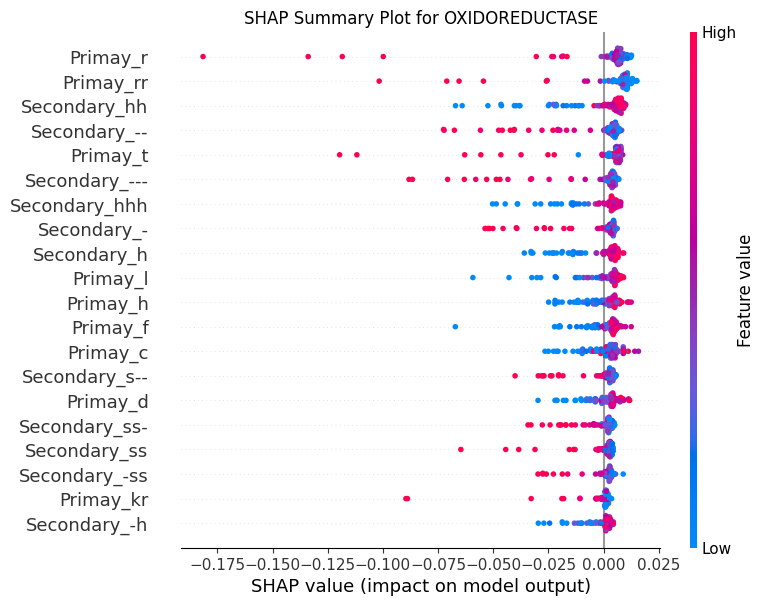

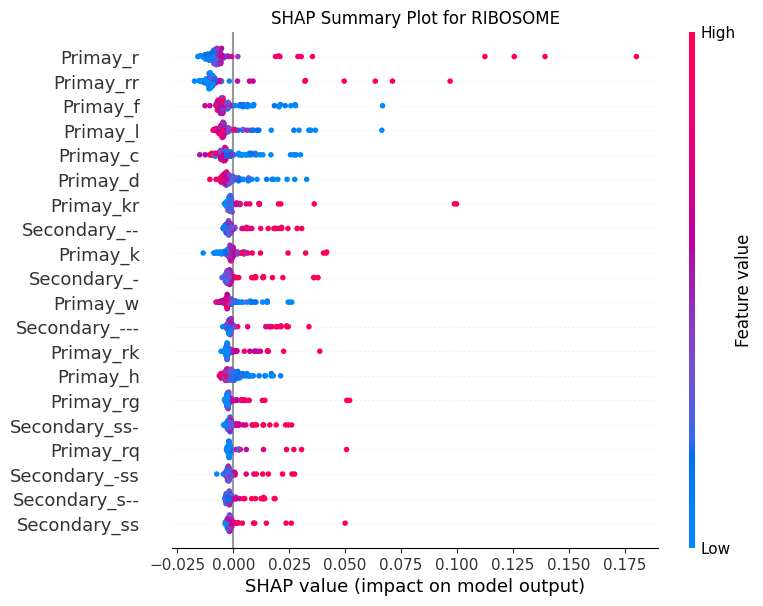

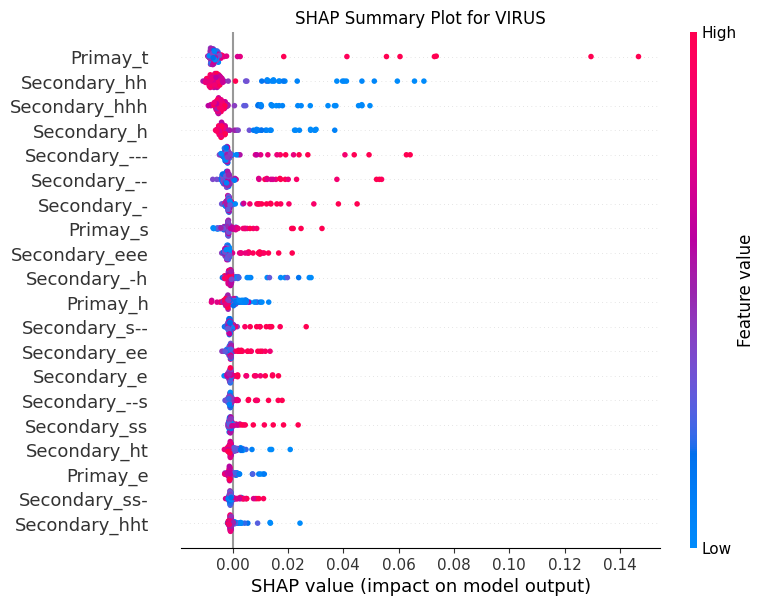

In [ ]:
# Get the original class names from the label encoder
class_names = label_encoder.inverse_transform(range(shap_values.shape[2]))  # Assuming label_encoder is the encoder

for i in range(shap_values.shape[2]):  # Loop through each class
    shap.summary_plot(
        shap_values[:, :, i],  # SHAP values for the i-th class
        X_test_subset,  # Subset of test data
        feature_names=feature_names,
        show=False,# Set show=False so that the plot doesn't display immediately
        plot_size=[8,6]
    )
    plt.title(f'SHAP Summary Plot for {target_names[i]}')  # Use original class names
    plt.show()  # Display the plot


In [ ]:
print(f"SHAP Values Shape: {np.array(shap_values).shape}")
print(f"X_test_subset Shape: {X_test_subset.shape}")
print(f"Feature Names Count: {len(tfidf_vectorizer.get_feature_names_out())}")

SHAP Values Shape: (500, 1000, 20)
X_test_subset Shape: (500, 1000)
Feature Names Count: 1000


**LIME ANALYSIS**

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b8609e4e3d7754ceb65d4e773c1965ecffbc50ce7b7662faa8555a00a5de7d28
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
feature_names = combined_feature_names

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer1 = LimeTabularExplainer(
    X_train,  # Training data (TF-IDF vectors)
    feature_names=feature_names,  # Feature names
    class_names=target_names,  # Replace with your class labels
    random_state=42,
    discretize_continuous=True
)

Note: structure ids used as examples are 0, 10005, 22214, 31141, 40608 form x_test for local interpretability analysis

In [ ]:
prediction = models["Random Forest"].predict(X_test[0].reshape(1, -1))
predicted_label = label_encoder.inverse_transform([prediction])[0]  # Get the predicted class
print(f"Predicted class: {predicted_label}")

Predicted class: OXIDOREDUCTASE


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
np.random.seed(42)
exp1 = explainer1.explain_instance(
    data_row=X_test[0],  # Replace with a test sample
    predict_fn=models['Random Forest'].predict_proba,  # Prediction function
    num_features=10, # Number of features to show
    top_labels=2,
)

In [ ]:
print(exp1.available_labels())  # Shows available labels

[9, 16]


In [ ]:
print("LIME for Random Forest model with combined sequence")
print("\ninstance: strID X_test[40608]\n")
exp1.show_in_notebook()
print("\nfeature values as list for top label\n")
exp1.as_list(label=9)

LIME for Random Forest model with combined sequence

instance: strID X_test[40608]




feature values as list for top label



[('Secondary_g-i <= 0.00', -0.037467029091567176),
 ('Secondary_i-g <= 0.00', -0.0374321462105965),
 ('Secondary_bhi <= 0.00', 0.027327850609049922),
 ('Secondary_sti <= 0.00', 0.02732785060904989),
 ('Secondary_ite <= 0.00', 0.022756749329403768),
 ('Secondary_hsi <= 0.00', -0.021206965345867704),
 ('Secondary_ip <= 0.00', -0.01947205297039884),
 ('Secondary_ibt <= 0.00', -0.01596341361543294),
 ('Secondary_-pt <= 0.00', 0.01440523163610814),
 ('Secondary_ipp <= 0.00', 0.010077696125574258)]